In [1]:
import random
import time
import math
import copy
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence
from torch.nn.utils.rnn import pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dataset import nmtDataset
import helpers as utils

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
hyp_params = {
    "batch_size": 64,
    "num_epochs": 10,

    # Encoder parameters
    "encoder_embedding_size": 512,
    "encoder_dropout": 0, # Disabled dropout because now we are only using single layer LSTM

    # Decoder parameters
    "decoder_dropout": 0,
    "decoder_embedding_size": 512,

    # Common parameters
    "hidden_size": 512,
    "num_layers": 1
}

In [4]:
log = utils.Logger('logs/emd512-enc2-dec2--attention-mask.out')  

In [4]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        # Shape (hidden): --> [num_layers * 2, batch_size, hidden_size]
        # encoder_outputs: Shape --> [Sequence_length , batch_size , hidden_size * 2]
        
        # Making hidden layer -> [batch size, hidden_size]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # Repeating hidden state for every sentences to the maximum sentence length
        # Shape (hidden): --> [batch size, src len, hidden_size]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Sentences are in column (see enc_out shape), so instead we want each sentence
        # in a row. Hence, we are permuting it
        # Shape (encoder_outputs): --> [batch size, src len, hidden_size * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # Concatenation will put hidden states with relavant sentence and with the each
        # word of the sentence
        # Shape (energy): --> [batch size, src len, hidden_size]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        # Shape (attention): --> [batch size, src len]
        attention = self.v(energy).squeeze(2)
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim=1)

In [5]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout):
        super(Encoder, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.LSTM = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout=dropout, bidirectional = True)
        
    def forward(self, x, src_lens):
        # Shape (embedding) --> [Sequence_length , batch_size , embedding dims]
        embedding = self.dropout(self.embedding(x))
        
        packed_embedded = pack_padded_sequence(embedding, src_lens.to('cpu'))
        
        # ************** Multiplied by 2 because of bi-directional LSTM
        # Shape --> (output) [Sequence_length , batch_size , hidden_size * 2]
        # Shape --> (hs, cs) [num_layers * 2, batch_size, hidden_size]
        packed_outputs, (hidden_state, cell_state) = self.LSTM(packed_embedded)
        
        outputs, _ = pad_packed_sequence(packed_outputs)
        
        return outputs, hidden_state, cell_state
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, dropout, output_size):
        super(Decoder, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hidden_size, hidden_size)
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
         # ************** Multiplying 2 because of bi-directional LSTM
        self.LSTM = nn.LSTM((hidden_size * 2) + embedding_dim, hidden_size, num_layers * 2, dropout=dropout)
        
        self.fc = nn.Linear((hidden_size* 2) + hidden_size + embedding_dim, output_size)
    
    def forward(self, x, enc_outputs, hidden_state, cell_state, mask):
        # As we are not feeding whole sentence we will each token a time
        # hence our sequence length would be just 1 however shape of x is batch_size
        # to add sequence length we will unsequeeze it
        # Shape (x) --> [batch_size] (see seq2seq model) so making it [1, batch_size]
        x = x.unsqueeze(0)
        
        # Shape (embedded) --> (1, batch_size, embedding dims)
        embedded = self.dropout(self.embedding(x))
        
        # Shape (a): --> [batch_size, src len]
        a = self.attention(hidden_state, enc_outputs, mask)
        
        # Shape (a): --> [batch_size, 1, src len]
        a = a.unsqueeze(1)
        
        # Shape (encoder_outputs): --> [batch_size, src len, hidden_size * 2]
        enc_outputs = enc_outputs.permute(1, 0, 2)
        
        # Shape (weighted): --> [batch_size, 1, hidden_size * 2]
        weighted = torch.bmm(a, enc_outputs)
        
        # Shape (weighted): --> [1, batch_size, hidden_size * 2]
        weighted = weighted.permute(1, 0, 2)
        
        # Shape (rnn_input): --> [1, batch_size, (hidden_size * 2) + embedding dims]
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        # Shape (output): --> [1, batch_size, hidden_size]
        # Shape (hidden_state, cell_state): --> [num_layers * num_directions, batch_size, hidden_size]
        outputs, (hidden_state, cell_state) = self.LSTM(rnn_input, (hidden_state, cell_state))
        
        embedded = embedded.squeeze(0) # Shape (output): --> [batch_size, hidden_size]
        outputs = outputs.squeeze(0) # Shape (output): --> [batch_size, hidden_size]
        weighted = weighted.squeeze(0) # Shape (output): --> [batch_size, hidden_size * 2]
        
        # Shape (predictions): --> [batch_size, output_size]
        predictions = self.fc(torch.cat((outputs, weighted, embedded), dim = 1))
        
        return predictions, hidden_state, cell_state, a.squeeze(1)

class SeqtoSeq(nn.Module):
    def __init__(self, gen_params, target_vocab, src_pad_idx, device):
        super(SeqtoSeq, self).__init__()

        self.Encoder = Encoder(gen_params["input_size_encoder"],
                          gen_params["encoder_embedding_size"],
                          gen_params["hidden_size"],
                          gen_params["num_layers"],
                          gen_params["encoder_dropout"]).to(device)

        self.Decoder = Decoder(gen_params["input_size_decoder"],
                          gen_params["decoder_embedding_size"],
                          gen_params["hidden_size"],
                          gen_params["num_layers"],
                          gen_params["decoder_dropout"],
                          gen_params["output_size"]).to(device)

        self.target_vocab = target_vocab
        self.src_pad_idx = src_pad_idx
        self.device = device
    
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
    
    def forward(self, source, src_lens, target, tfr=0.5):
        # (source) Shape -> (Sentence length, Batch_size)
        batch_size = source.shape[1]

        target_len = target.shape[0]  # Length of target sentences
        target_vocab_size = len(self.target_vocab)
        
        # here we will store all the outputs
        # so outputs is arrange in a way that sentences are in column and batch size is row and every element
        # will consist of probability of each word from the vocab
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)

        # Shape --> (hs, cs) (num_layers * 2, batch_size size, hidden_size) (contains encoder's hs, cs - context vectors)
        enc_outputs, hidden_state, cell_state = self.Encoder(source, src_lens)

        # Shape (target) -> (Sentence length, Batch_size)
        # Shape (x) --> (batch_size)
        x = target[0]  # First token (Trigger)
        
        mask = self.create_mask(source)
        
        for i in range(1, target_len):
            # Shape (output) --> (batch_size, target_vocab_size)
            # Shape (hs, cl) --> (num_layers * 2, batch_size , hidden_size)
            # _ is attention which we dont need here!
            output, hidden_state, cell_state, _ = self.Decoder(x, enc_outputs, hidden_state, cell_state, mask)
            outputs[i] = output
            best_guess = output.argmax(1)  # 0th dimension is batch size, 1st dimension is word embedding
            # Schedule sampling
            x = target[
                i] if random.random() < tfr else best_guess  # Either pass the next word correctly from the dataset
            # or use the earlier predicted word

        # Shape --> (sentence length, batch size, vocab size)
        return outputs

In [6]:
nmtds_train = nmtDataset('datasets/Multi30k/', 'train')
nmtds_valid = nmtDataset('datasets/Multi30k/', 'val', nmtds_train)
nmtds_test = nmtDataset('datasets/Multi30k/', 'test', nmtds_train)

In [7]:
train_dataloader = DataLoader(nmtds_train, batch_size=hyp_params['batch_size'], shuffle=True,
                              collate_fn=lambda batch_size: utils.collate_fn(batch_size, device))

valid_dataloader = DataLoader(nmtds_valid, batch_size=hyp_params['batch_size'], shuffle=True,
                              collate_fn=lambda batch_size: utils.collate_fn(batch_size, device))

In [8]:
hyp_params["input_size_encoder"] = len(nmtds_train.src_vocab)
hyp_params["input_size_decoder"] = len(nmtds_train.trg_vocab)
hyp_params["output_size"] = len(nmtds_train.trg_vocab)

pad_idx = nmtds_train.trg_vocab["<pad>"]

model = SeqtoSeq(hyp_params, nmtds_train.trg_vocab, pad_idx, device=device)
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx).to(device)

In [12]:
min_el = math.inf
patience = 1
best_model = {}
best_epoch = 0

epoch_loss = 0
for epoch in range(hyp_params["num_epochs"]):
    start = time.time()
    
    gc.collect()
    torch.cuda.empty_cache()
    
    epoch_loss = utils.train_model(model, train_dataloader, criterion, optimizer)
    eval_loss = utils.evaluate_model(model, valid_dataloader, criterion)
    
    log.log(f"Epoch: {epoch+1}, Train loss: {epoch_loss}, Eval loss: {eval_loss}, patience: {patience}. Time {time.time() - start}")

    
    if eval_loss < min_el:
        best_epoch = epoch+1
        min_el = eval_loss
        best_model = copy.deepcopy(model)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'eval_loss': min_el
        }, 'model-attention-mask.pt')
        patience = 1
    else:
        patience += 1
    
    if patience == 10:
        log.log("[STOPPING] Early stopping in action..")
        log.log(f"Best epoch was {best_epoch} with {min_el} eval loss")
        break

log.close()

100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:26<00:00,  1.70it/s]


Epoch: 1, Train loss: 4.036502361297607, Eval loss: 3.6849288940429688, patience: 1. Time 269.5607063770294


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:30<00:00,  1.68it/s]


Epoch: 2, Train loss: 2.7752346992492676, Eval loss: 3.50978422164917, patience: 1. Time 273.2232222557068


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:26<00:00,  1.71it/s]


Epoch: 3, Train loss: 2.223062753677368, Eval loss: 3.468437671661377, patience: 1. Time 268.95871663093567


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:26<00:00,  1.70it/s]


Epoch: 4, Train loss: 1.9067353010177612, Eval loss: 3.5798776149749756, patience: 1. Time 269.2954339981079


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:24<00:00,  1.72it/s]


Epoch: 5, Train loss: 1.672776460647583, Eval loss: 3.7656922340393066, patience: 2. Time 266.9526059627533


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:25<00:00,  1.71it/s]


Epoch: 6, Train loss: 1.4685840606689453, Eval loss: 3.8416030406951904, patience: 3. Time 268.22689032554626


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:24<00:00,  1.72it/s]


Epoch: 7, Train loss: 1.2867000102996826, Eval loss: 4.060118675231934, patience: 4. Time 266.9730188846588


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:24<00:00,  1.72it/s]


Epoch: 8, Train loss: 1.1393797397613525, Eval loss: 4.2660298347473145, patience: 5. Time 267.64373326301575


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:24<00:00,  1.72it/s]


Epoch: 9, Train loss: 1.0300096273422241, Eval loss: 4.404290676116943, patience: 6. Time 267.55672335624695


100%|████████████████████████████████████████████████████████████████████████████████| 454/454 [04:24<00:00,  1.72it/s]


Epoch: 10, Train loss: 0.9518680572509766, Eval loss: 4.612933158874512, patience: 7. Time 267.21500062942505


In [10]:
hyp_params["input_size_encoder"] = len(nmtds_train.src_vocab)
hyp_params["input_size_decoder"] = len(nmtds_train.trg_vocab)
hyp_params["output_size"] = len(nmtds_train.trg_vocab)


model_l = SeqtoSeq(hyp_params, nmtds_train.trg_vocab, pad_idx, device=device)
model_l.load_state_dict(torch.load('model-attention-mask.pt', map_location=device)["model_state_dict"])

<All keys matched successfully>

In [13]:
utils.bleu(model_l, nmtds_test, True, device)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.37it/s]


0.2693709135055542

D:\maq\nmt\env\lib\site-packages\ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app
D:\maq\nmt\env\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


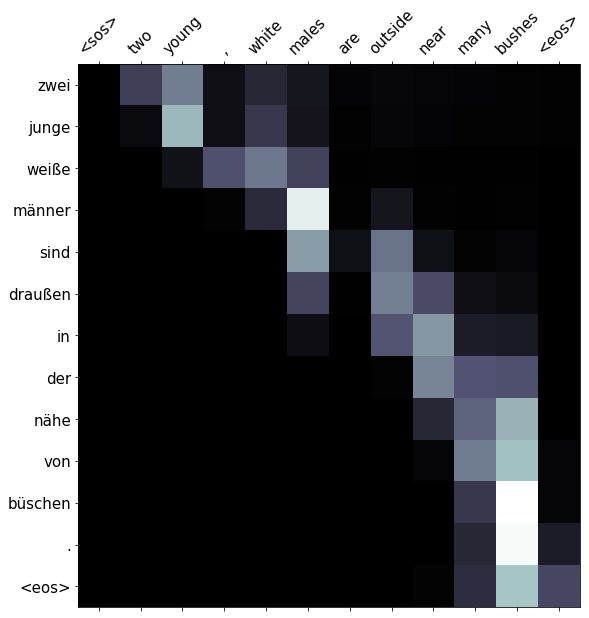

In [14]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()
    
def translate(tokens, dataset, model, device):
    indices = [dataset.src_vocab['<sos>']] + dataset.src_vocab.lookup_indices(tokens) + [dataset.src_vocab['<eos>']]
    inp_tensor = torch.tensor(indices).unsqueeze(1).to(device)

    # Build encoder hidden, cell state
    with torch.no_grad():
        eouts, hidden, cell = model.Encoder(inp_tensor)

    outputs = [dataset.trg_vocab["<sos>"]]
    mask = model.create_mask(inp_tensor)
    attentions = torch.zeros(50, 1, len(indices)).to(device)

    for i in range(50):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            output, hidden, cell, attention = model.Decoder(previous_word, eouts, hidden, cell, mask)
            attentions[i] = attention
            best_guess = output.argmax(1).item()

        outputs.append(best_guess)

        # M odel predicts it's the end of the sentence
        if output.argmax(1).item() == dataset.trg_vocab['<eos>']:
            break

    trg_tokens = dataset.trg_vocab.lookup_tokens(outputs)
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

src = 'Two young, White males are outside near many bushes'
src_tokens = nmtds_train.tokenizers['en'](src.lower().strip())
translation, attention = translate(src_tokens, nmtds_train, model_l, device)
translation
display_attention(src_tokens, translation, attention)